In [2]:
 """
    Make a fits image cube using parameters from an input catalog
      - The number of images in the cube matches the number of rows in the catalog.
      - Each image size is computed automatically by GalSim based on the Nyquist size.
      - Only galaxies.  No stars.
      - PSF is Moffat
      - Each galaxy is bulge plus disk: deVaucouleurs + Exponential.
      - A fraction of the disk flux is placed into point sources, which can model
        knots of star formation.
      - The catalog's columns are:
         0 PSF beta (Moffat exponent)
         1 PSF FWHM
         2 PSF e1
         3 PSF e2
         4 PSF trunc
         5 Disc half-light-radius
         6 Disc e1
         7 Disc e2
         8 Bulge half-light-radius
         9 Bulge e1
        10 Bulge e2
        11 Galaxy dx (the two components have same center)
        12 Galaxy dy
      - Applied shear is the same for each galaxy
      - Noise is Poisson using a nominal sky value of 1.e6
    """
# Copyright (c) 2012-2021 by the GalSim developers team on GitHub
# https://github.com/GalSim-developers
#
# This file is part of GalSim: The modular galaxy image simulation toolkit.
# https://github.com/GalSim-developers/GalSim
#
# GalSim is free software: redistribution and use in source and binary forms,
# with or without modification, are permitted provided that the following
# conditions are met:
#
# 1. Redistributions of source code must retain the above copyright notice, this
#    list of conditions, and the disclaimer given in the accompanying LICENSE
#    file.
# 2. Redistributions in binary form must reproduce the above copyright notice,
#    this list of conditions, and the disclaimer given in the documentation
#    and/or other materials provided with the distribution.
#
"""
Demo #4

The fourth script in our tutorial about using GalSim in python scripts: examples/demo*.py.
(This file is designed to be viewed in a window 100 characters wide.)

This script is our first one to create multiple images.  Typically, you would want each object
to have at least some of its attributes vary when you are drawing multiple images (although 
not necessarily -- you might just want different noise realization of the same profile).  
The easiest way to do this is to read in the properties from a catalog, which is what we
do in this script.  The PSF is a truncated Moffat profile, and the galaxy is bulge plus disk,
with knots of star formation modeled as point sources distributed according to a random walk.
Both components get many of their parameters from an input catalog.  We also shift the 
profile by a fraction of a pixel in each direction so the effect of pixelization varies
among the images.  Each galaxy has the same applied shear.  The noise is simple Poisson noise.
We write the images out into a multi-extension fits file.

New features introduced in this demo:

- cat = galsim.Catalog(file_name, dir)
- obj = galsim.Moffat(beta, fwhm, trunc)
- obj = galsim.DeVaucouleurs(flux, half_light_radius=)
- obj = galsim.RandomKnots(npoints, half_light_radius=, flux=)
- obj = galsim.Add([list of objects])
- obj = obj.shift(dx,dy)
- galsim.fits.writeMulti([list of images], file_name)
"""

import sys
import os
import math
import numpy
import logging
import time
import galsim

def main(argv):
   
    logging.basicConfig(format="%(message)s", level=logging.INFO, stream=sys.stdout)
    logger = logging.getLogger("demo4")

    # Define some parameters we'll use below and make directories if needed.
    cat_file_name = os.path.join('input','galsim_default_input.asc')
    if not os.path.isdir('output'):
        os.mkdir('output')
    multi_file_name = os.path.join('output','multi.fits')

    random_seed = 8241573
    sky_level = 1.e6                # ADU / arcsec^2
    pixel_scale = 1.0               # arcsec / pixel  (size units in input catalog are pixels)
    gal_flux = 1.e6                 # arbitrary choice, makes nice (not too) noisy images
    gal_g1 = -0.009                 #
    gal_g2 = 0.011                  #

    # the fraction of flux in each component
    # 40% is in the bulge, 60% in a disk.  70% of that disk light is placed
    # into point sources distributed as a random walk

    bulge_frac       = 0.4
    disk_frac        = 0.6
    knot_frac        = 0.42
    smooth_disk_frac = 0.18

    # number of knots of star formation.  To simulate a nice irregular (all the
    # flux is in knots) we find ~100 is a minimum number needed, but we will
    # just use 10 here to make the demo run fast.

    n_knots = 10

    xsize = 64                      # pixels
    ysize = 64                      # pixels

    logger.info('Starting demo script 4 using:')
    logger.info('    - parameters taken from catalog %r',cat_file_name)
    logger.info('    - Moffat PSF (parameters from catalog)')
    logger.info('    - pixel scale = %.2f',pixel_scale)
    logger.info('    - Bulge + Disc galaxies (parameters from catalog)')
    logger.info('    - 100 Point sources, distributed as random walk')
    logger.info('    - Applied gravitational shear = (%.3f,%.3f)',gal_g1,gal_g2)
    logger.info('    - Poisson noise (sky level = %.1e).', sky_level)

    # Read in the input catalog
    cat = galsim.Catalog(cat_file_name)


    # save a list of the galaxy images in the "images" list variable:
    images = []
    for k in range(cat.nobjects):
        # Initialize the (pseudo-)random number generator that we will be using below.
        # Use a different random seed for each object to get different noise realizations.
        # Using sequential random seeds here is safer than it sounds.  We use Mersenne Twister
        # random number generators that are designed to be used with this kind of seeding.
        # However, to be extra safe, we actually initialize one random number generator with this
        # seed, generate and throw away two random values with that, and then use the next value
        # to seed a completely different Mersenne Twister RNG.  The result is that successive
        # RNGs created this way produce very independent random number streams.
        rng = galsim.BaseDeviate(random_seed+k+1)

        # Take the Moffat beta from the first column (called 0) of the input catalog:
        # Note: cat.get(k,col) returns a string.  To get the value as a float, use either
        #       cat.getFloat(k,col) or float(cat.get(k,col))
        beta = cat.getFloat(k,0)
        # A Moffat's size may be either scale_radius, fwhm, or half_light_radius.
        # Here we use fwhm, taking from the catalog as well.
        fwhm = cat.getFloat(k,1)
        # A Moffat profile may be truncated if desired
        # The units for this are expected to be arcsec (or specifically -- whatever units
        # you are using for all the size values as defined by the pixel_scale).
        trunc = cat.getFloat(k,4)
        # Note: You may omit the flux, since the default is flux=1.
        psf = galsim.Moffat(beta=beta, fwhm=fwhm, trunc=trunc)

        # Take the (e1, e2) shape parameters from the catalog as well.
        psf = psf.shear(e1=cat.getFloat(k,2), e2=cat.getFloat(k,3))

        # Galaxy is a bulge + disk(+knots) with parameters taken from the catalog:

        # put some fraction of the disk light into knots of star formation

        disk_hlr = cat.getFloat(k,5)
        disk_e1 = cat.getFloat(k,6)
        disk_e2 = cat.getFloat(k,7)
        bulge_hlr = cat.getFloat(k,8)
        bulge_e1 = cat.getFloat(k,9)
        bulge_e2 = cat.getFloat(k,10)

        smooth_disk = galsim.Exponential(flux=smooth_disk_frac, half_light_radius=disk_hlr)

        knots = galsim.RandomKnots(n_knots, half_light_radius=disk_hlr, flux=knot_frac, rng=rng)

        disk = galsim.Add([smooth_disk, knots])
        disk = disk.shear(e1=disk_e1, e2=disk_e2)

        # the rest of the light goes into the bulge
        bulge = galsim.DeVaucouleurs(flux=bulge_frac, half_light_radius=bulge_hlr)
        bulge = bulge.shear(e1=bulge_e1, e2=bulge_e2)

        # The flux of an Add object is the sum of the component fluxes.
        # Note that in demo3.py, a similar addition was performed by the binary operator "+".
        gal = galsim.Add([disk, bulge])

        # This flux may be overridden by withFlux.  The relative fluxes of the components
        # remains the same, but the total flux is set to gal_flux.
        gal = gal.withFlux(gal_flux)
        gal = gal.shear(g1=gal_g1, g2=gal_g2)

        # The center of the object is normally placed at the center of the postage stamp image.
        # You can change that with shift:
        gal = gal.shift(dx=cat.getFloat(k,11), dy=cat.getFloat(k,12))

        final = galsim.Convolve([psf, gal])

        # Draw the profile
        image = galsim.ImageF(xsize, ysize)
        final.drawImage(image, scale=pixel_scale)

        # Add Poisson noise to the image:
        image.addNoise(galsim.PoissonNoise(rng, sky_level * pixel_scale**2))

        logger.info('Drew image for object at row %d in the input catalog'%k)
   
        # Add the image to our list of images
        images.append(image)
    
    # Now write the images to a multi-extension fits file.  Each image will be in its own HDU.
    galsim.fits.writeMulti(images, multi_file_name)
    logger.info('Images written to multi-extension fits file %r',multi_file_name)


if __name__ == "__main__":
    main(sys.argv)

Starting demo script 4 using:
    - parameters taken from catalog 'input/galsim_default_input.asc'
    - Moffat PSF (parameters from catalog)
    - pixel scale = 1.00
    - Bulge + Disc galaxies (parameters from catalog)
    - 100 Point sources, distributed as random walk
    - Applied gravitational shear = (-0.009,0.011)
    - Poisson noise (sky level = 1.0e+06).
Drew image for object at row 0 in the input catalog
Drew image for object at row 1 in the input catalog
Drew image for object at row 2 in the input catalog
Drew image for object at row 3 in the input catalog
Drew image for object at row 4 in the input catalog
Drew image for object at row 5 in the input catalog
Drew image for object at row 6 in the input catalog
Drew image for object at row 7 in the input catalog
Drew image for object at row 8 in the input catalog
Drew image for object at row 9 in the input catalog
Drew image for object at row 10 in the input catalog
Drew image for object at row 11 in the input catalog
Drew im

In [1]:
from astropy.utils.data import download_file
from astropy.io import fits
image_file = "output//multi.fits"
hdulist = fits.open(image_file)
hdulist.info()


Filename: output//multi.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      20   (64, 64)   float32   
  1                1 ImageHDU        21   (64, 64)   float32   
  2                1 ImageHDU        21   (64, 64)   float32   
  3                1 ImageHDU        21   (64, 64)   float32   
  4                1 ImageHDU        21   (64, 64)   float32   
  5                1 ImageHDU        21   (64, 64)   float32   
  6                1 ImageHDU        21   (64, 64)   float32   
  7                1 ImageHDU        21   (64, 64)   float32   
  8                1 ImageHDU        21   (64, 64)   float32   
  9                1 ImageHDU        21   (64, 64)   float32   
 10                1 ImageHDU        21   (64, 64)   float32   
 11                1 ImageHDU        21   (64, 64)   float32   
 12                1 ImageHDU        21   (64, 64)   float32   
 13                1 ImageHDU        21   (64, 64)   float32   
 14          

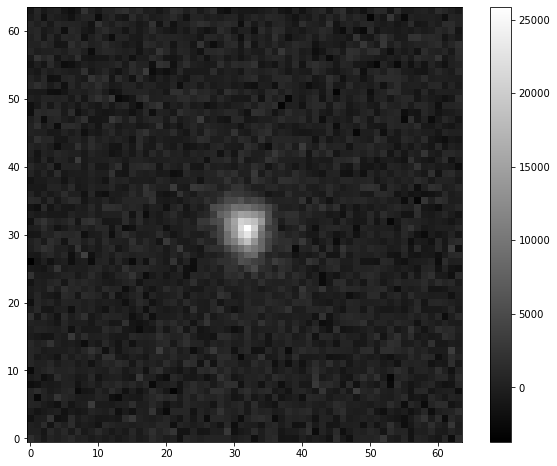

In [5]:
#try 1st image
import matplotlib.pyplot as plt
hdu = hdulist[0]
#numpy swap rows and cols
plt.figure(figsize=(10,8))
plt.imshow(hdu.data.T, cmap='gray', origin='lower')
plt.colorbar();

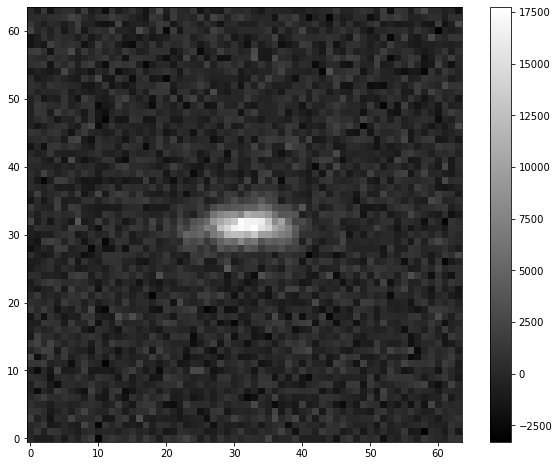

In [7]:
#try 77th image
hdu = hdulist[77]
#numpy swap rows and cols
plt.figure(figsize=(10,8))
plt.imshow(hdu.data.T, cmap='gray', origin='lower')
plt.colorbar();